In [1]:
from scipy import stats
import xarray as xr
import pandas as pd
import numpy as np
import gcsfs
from glob import glob
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def load(url,start_year):
    ds = xr.open_dataset(url,decode_times=False)
    if 'T' in ds.coords:
        ds = ds.rename({'T':'time'})
    if 'X' in ds.coords:
        ds = ds.rename({'X':'lon','Y':'lat'})
    if 'longitude' in ds.coords:
        ds = ds.rename({'longitude':'lon','latitude':'lat'})
    if 'ts' in ds.data_vars:
        ds = ds.rename({'ts':'sst'})
    # make lon 0 to 360 
    ds.coords['lon'] = np.mod(ds['lon'], 360)
    ds = ds.reindex({ 'lon' : np.sort(ds['lon'])})
    # make lat increasing
    ds = ds.sortby('lat')
    ds['time'] = pd.date_range('01/01/'+str(start_year), periods=len(ds.time), freq='MS').shift(15, freq='D') 
    return ds

In [3]:
# NS index
xNS_W = 190; xNS_E = 240;
yNS_N = 9; yNS_Eq = 3; 

# EW index
xEW_W1 = 140; xEW_E1 = 170; 
xEW_W2 = 190; xEW_E2 = 270; 
yWE = 3;

import xesmf as xe
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-20.5,20.6, 1)),
                     'lon': (['lon'], np.arange(120.5,291,1)),
                                })

In [4]:
url = {}
# These must all be monthly datasets!!
url['HadISST'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.HadISST/.HadISST_sst.nc/.sst/dods'
url['ORAs5'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.ORAs5/.ingrid-ready/.sst.nc/.sst/dods'
url['COBE'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.COBE-SST/.sst.mon.mean.nc/.sst/dods'
url['COBE2']= 'http://kage.ldeo.columbia.edu:81/home/.datasets/.COBE-SST2/.sst.mon.mean.nc/.sst/dods'
url['ERSSTv5'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.ERSST/.ERSSTv5.nc/.sst/zlev/removeGRID/dods'
start = {'HadISST':1870,'ORAs5':1958,'COBE':1891,'COBE2':1850,'ERSSTv5':1854}

prods = url.keys()
dss = {}
dss_EW = {}
dss_NS = {}
for prod in prods:
    dsp = load(url[prod],start[prod]).sel(time=slice('1958-01','2018-12')).coarsen(time=12,boundary='trim').mean()
    dsr = dsp
    dss[prod] = dsr
    dW = dsr.sel(lon= slice(xEW_W1,xEW_E1),lat=slice(-yWE,yWE)).mean(['lon','lat'])
    dE = dsr.sel(lon= slice(xEW_W2,xEW_E2),lat=slice(-yWE,yWE)).mean(['lon','lat'])
    dss_EW[prod] = -(dE-dW)
    dS = dsr.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_N,-yNS_Eq)).mean(['lon','lat'])
    dN = dsr.sel(lon=slice(xNS_W,xNS_E),lat=slice( yNS_Eq, yNS_N)).mean(['lon','lat'])
    dEQ = dsr.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_Eq, yNS_Eq)).mean(['lon','lat'])
    dss_NS[prod] = (0.5*(dS + dN) - dEQ)

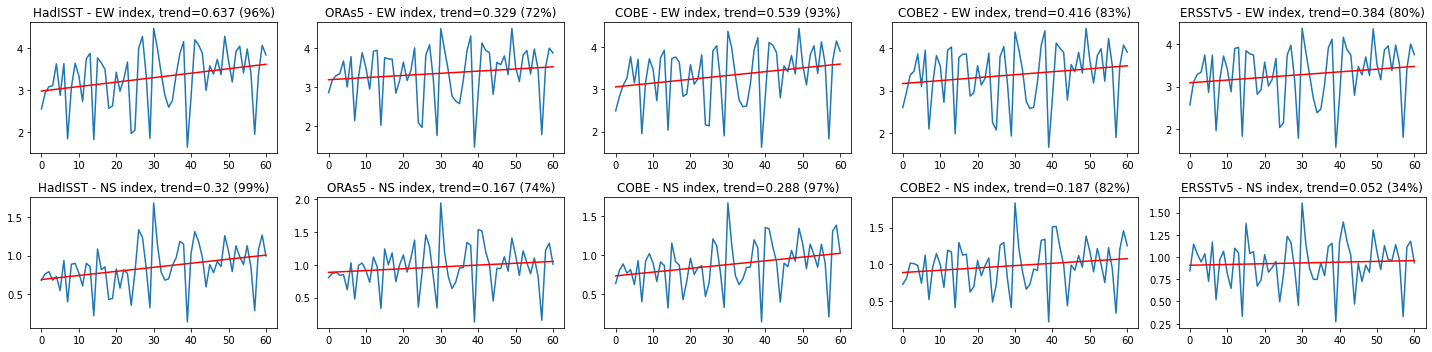

In [5]:
fig, axs = plt.subplots(2,5,figsize=(20,5))

for j,index in enumerate(['EW','NS']):
    if index=='EW':
        dsss = dss_EW
        vmin=1;vmax=5
    else:
        dsss = dss_NS
        vmin=0;vmax=2
    for i,prod in enumerate(prods):
        ax = axs[j,i]
        ds = dsss[prod].sel(time=slice('1958-01','2018-12'))

        NT = len(ds.time)
        x = np.arange(0,NT)
        y = ds.sst.values
        ax.plot(x,y)

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        trend = (NT-1)*slope
        sig = 100*(1-p_value)
        bfl =  intercept + slope * x
        ax.plot(x, bfl , 'r')

        ax.set_title(f'{prod} - {index} index, trend={trend.round(3)} ({round(sig)}%)')
plt.tight_layout()

In [8]:
# In order to use scipy linregress efficiently with multidimensional xarray datasets, we use 'apply_ufunc':

def linregress_1d(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

def linregress_xr(da,dim='time'):
    NT = len(da[dim])
    da[dim] = np.arange(0,NT) 
    stats = xr.apply_ufunc(linregress_1d, da[dim], da,
                           input_core_dims=[[dim], [dim]],
                           output_core_dims=[["parameter"]],
                           vectorize=True,
                           dask="parallelized",
                           output_dtypes=['float32'],
                           output_sizes={"parameter": 5},
                          ) 
    ds = ((NT-1)*stats[:,:,0]).to_dataset(name='trend')
    ds['pvalue'] = stats[:,:,3]
    return ds

/usr/local/python/anaconda3/envs/pangeo-Oct2021/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


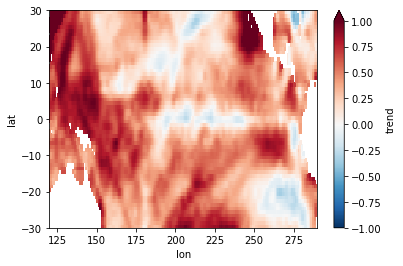

In [15]:
prod = 'HadISST'
ds = dss[prod]
ds_stats = linregress_xr(ds.sst.sel(lon=slice(120,290),lat=slice(-30,30)))
ds_stats.trend.plot(vmin=-1,vmax=1,cmap='RdBu_r')

Text(-78, -8, 'Latitude')

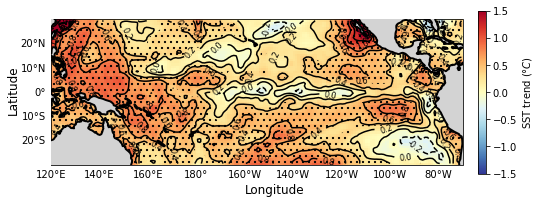

In [18]:
# Or a fancier version (with stippling for 95% confidence)
import cartopy.crs as ccrs
import cartopy.feature as cfeature

alpha = 0.05
fig, axs = plt.subplots(figsize=(9, 6))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180));

cm = plt.get_cmap("RdYlBu_r")
an_image = ds_stats.trend.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
            vmin=-1.5, vmax=1.5, cmap=cm, add_colorbar=False, rasterized=True);
cbar = plt.colorbar(an_image, shrink=0.5, pad=.03)
cbar.set_label(r'SST trend ($\degree C$)')

CS = ds_stats.trend.plot.contour(ax=ax, transform=ccrs.PlateCarree(),vmin=-2,vmax=2,colors='k',levels=21)
ax.clabel(CS, inline=1, fontsize=8, fmt='%1.1f')
ax.add_feature(cfeature.LAND, zorder=5, color='lightgrey', edgecolor='black', alpha=1.0)

ds_stats.pvalue.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=[alpha,1.0],colors='none',hatches=['..',None],extend='both',add_colorbar=0)
ax.coastlines(linewidth=2,zorder=6);

ax.set_extent((120, 290, -30, 30), crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.0, xlocs=np.arange(-180,180,20))
gl.top_labels = False
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}
plt.text(20,-42,'Longitude',fontsize=12)
plt.text(-78,-8,'Latitude',fontsize=12,rotation=90)